RAINSTORM - Created on Nov 7, 2023 - @author: Santiago D'hers

@author: Santiago D'hers

## Create models
- This notebook will train AI models to identify exploration using the mouse and object position, and the labels of the viewers.

#### Requirements:

- A set of position files
- Labeled data for the position files (to train the model)

or

- Access to the example file **colabels.csv**, where we can find:
    - Position and labels for representative exploration events
    - It includes the labels of 5 viewers (so far)

---
#### 1. Load the necessary modules

In [ ]:
import os
import datetime
import rainstorm.modeling as rst

rainstorm.create_models successfully imported. GPU devices detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


---
#### 2. State your project path & thresholds
`base` : The path to the downloaded repository. If you are using a Windows path with backslashes, place an ‘r’ in front of the directory path to avoid an error (e.g. r'C:\Users\dhers\Desktop\RAINSTORM').

`objects` : Name the stationary objects that appear on your data.

`bodyparts` : Name the bodyparts you want to use for training (to simplify the model, it is better to leave out the tail).

`labelers` : Names of the people that labeled the data (they should be the same as the columns in the `colabels` file).

`past` & `future` : If you use a LSTM model, you can set the window size by saying how many frames into the past and how many into the future you want to see.

`broad` : Once you have your window size, we can broaden the window by skipping some frames as we stray further from the present.

In [2]:
# State your path:
base = r'C:\Users\dhers\Desktop\RAINSTORM'
models_folder = os.path.join(base, r'docs\models')
colabels = os.path.join(models_folder, 'colabels.csv')

objects = ['obj']
bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body']
labelers = ['Marian', 'Agus', 'Santi', 'Guille', 'Myself']

past, future = 3, 3 # if you use a LSTM model, you can set the window size here
broad = 1.7 # using the same amount of frames, set how broad the window is (skipping frames)
broad_frames = rst.broaden(past, future, broad)
print(f'LSTM frame window: {broad_frames}')

use_saved_data = True # if True, we use a previous training-testing-validation split
if use_saved_data:
    saved_data = os.path.join(models_folder, 'splits/split_example_7w.h5') # Select the data you want to rescue

else:
    train_with_average = True # If False, it trains with all the labels separately
    make_discrete = False # If False, labels are float (not 0 and 1)
    save_data = True # if True, the data processed will be saved with today's date

# Get the start time
start_time = datetime.datetime.now()

LSTM frame window: [-6, -3, -1, 0, 1, 3, 6]


---
#### 3. Before training a model, we need to prepare our training data
- First, we load the dataset from the colabels file and create one 'labels' column out of all the labelers.
- Next (optional, but recommended) we can erase the rows of the dataset that are too far away from exploration events.
- Finally, we split the dataset into training, testing and validation subsets.

In [3]:
if use_saved_data:
    X_tr_wide, X_tr, y_tr, X_ts_wide, X_ts, y_ts, X_val_wide, X_val, y_val = rst.load_split(saved_data)

else:

    # Prepare the data
    dataset = rst.prepare_data(colabels, labelers) # This method of importing data should be improved

    # Focus on the rows near exploratory behaviour
    dataset = rst.focus(dataset, distance = 25)

    X_tr_wide, X_tr, y_tr, X_ts_wide, X_ts, y_ts, X_val_wide, X_val, y_val = rst.split_tr_ts_val(dataset, objects, bodyparts, past, future, broad)
    
    # Print the sizes of each set
    print(f"Training set size: {len(X_tr)} samples")
    print(f"Validation set size: {len(X_val)} samples")
    print(f"Testing set size: {len(X_ts)} samples")
    print(f"Total samples: {len(X_tr)+len(X_val)+len(X_ts)}")

    if save_data:
        rst.save_split(models_folder, start_time, X_tr_wide, X_tr, y_tr, X_ts_wide, X_ts, y_ts, X_val_wide, X_val, y_val)

Data is ready to train


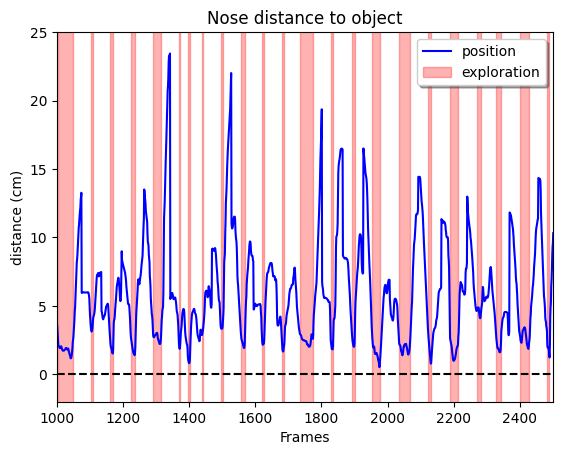

In [4]:
# We can see on the testing data that the exploratory events happen when the nose gets close to the object
rst.plot_example_data(X_ts, y_ts)

---
#### 4. With our training data ready, we can use TensorFlow to design our very first model
- It will look at the positions of one frame at a time, and try to decide if the mouse is exploring.
- If the decision is correct the architecture will be reinforced, else it will be corrected according to the learning rate.
- We will train it for some epochs (cycles through the whole dataset) and plot how the accuracy and loss evolve.
- Also, we will be validating the training using the validation split, which contains frames that were not used for training.

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

# Build a simple neural network
model_simple = tf.keras.Sequential([
    
    # Imput layer
    Input(shape=(X_tr.shape[1],)), 

    # Hidden layers
    Dense(32, activation='relu'),
    Dense(24, activation='relu'),
    Dense(16, activation='relu'),
    Dense(12, activation='relu'),
    Dense(8, activation='relu'),
    
    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile the model
model_simple.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                   loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
model_simple.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                416       
                                                                 
 dense_1 (Dense)             (None, 24)                792       
                                                                 
 dense_2 (Dense)             (None, 16)                400       
                                                                 
 dense_3 (Dense)             (None, 12)                204       
                                                                 
 dense_4 (Dense)             (None, 8)                 104       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,925
Trainable params: 1,925
Non-trainabl

In [7]:
# Train the model
history_simple = model_simple.fit(X_tr, y_tr,
                                  epochs=20, # An epoch is a complete pass through the entire training dataset.
                                  batch_size=64, # The batch size is the number of training samples the model processes before updating its weights.
                                  validation_data=(X_val, y_val))

Epoch 1/20
417/417 [==============================] - 2s 4ms/step - loss: 0.4445 - accuracy: 0.5936 - val_loss: 0.3466 - val_accuracy: 0.6243
Epoch 2/20
417/417 [==============================] - 2s 4ms/step - loss: 0.3119 - accuracy: 0.6761 - val_loss: 0.2839 - val_accuracy: 0.6619
Epoch 3/20
417/417 [==============================] - 2s 5ms/step - loss: 0.2639 - accuracy: 0.7001 - val_loss: 0.2705 - val_accuracy: 0.6592
Epoch 4/20
417/417 [==============================] - 2s 5ms/step - loss: 0.2468 - accuracy: 0.7049 - val_loss: 0.2635 - val_accuracy: 0.6617
Epoch 5/20
417/417 [==============================] - 2s 5ms/step - loss: 0.2389 - accuracy: 0.7065 - val_loss: 0.2591 - val_accuracy: 0.6638
Epoch 6/20
417/417 [==============================] - 2s 5ms/step - loss: 0.2341 - accuracy: 0.7083 - val_loss: 0.2586 - val_accuracy: 0.6613
Epoch 7/20
417/417 [==============================] - 2s 5ms/step - loss: 0.2305 - accuracy: 0.7101 - val_loss: 0.2527 - val_accuracy: 0.6659
Epoch 

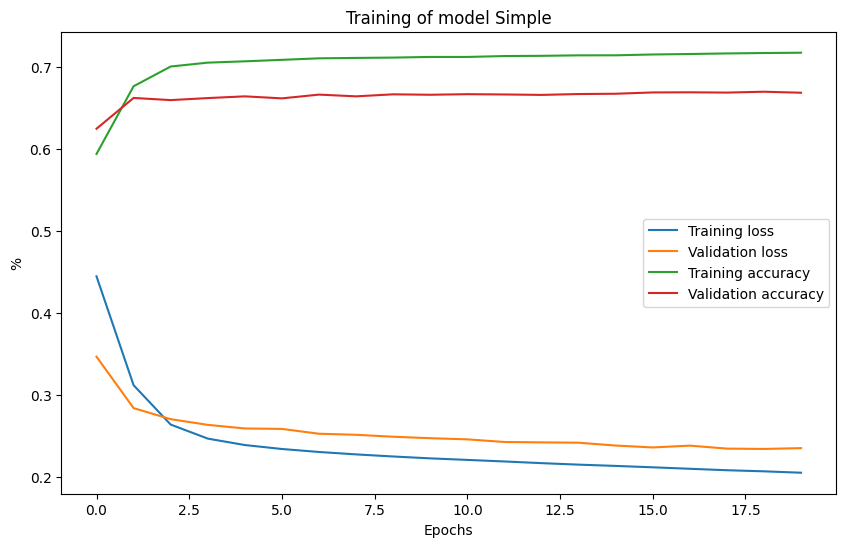

In [8]:
# Plot the training and validation loss
rst.plot_history(history_simple, "Simple")

In [9]:
y_pred_simple = model_simple.predict(X_ts)

# Calculate accuracy and precision of the model
accuracy_simple, precision_simple, recall_simple, f1_simple, mse_simple, mae_simple, r2_simple = rst.evaluate(y_pred_simple, y_ts, show_report = True)
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f}, MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")

165/165 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4022
           1       0.86      0.89      0.87      1243

    accuracy                           0.94      5265
   macro avg       0.91      0.92      0.92      5265
weighted avg       0.94      0.94      0.94      5265

Accuracy = 0.9390, Precision = 0.9400, Recall = 0.9390, F1 Score = 0.9394, MSE = 0.0281, MAE = 0.0795, R-squared = 0.8250 -> simple


In [10]:
# Save the model
model_simple.save(os.path.join(models_folder, f'm_simple/simple_{start_time.date()}.keras'))

---
#### 5. Now that we have a simple model trained, we can start building more complex models with the help of some functions

To make our artificial networks as real as possible, we can let them see a sequence of frames to decide if the mouse is exploring.
- Our build_LSTM_model function will use Bidirectional LSTM layers that allow the model to take into account the sequence of frames.
- With `units` we can say how many and how big our hidden layers will be.
- We also implement an early stopping and learning rate scheduler mechanisms that will prevent the model from overfitting.


In [39]:
# Set the number of neurons in each layer
input_shape = (X_tr_wide.shape[1], X_tr_wide.shape[2])
units = [64, 32, 16, 8]

batch_size = 128 # Set the batch size
lr = 0.0001 # Set the initial learning rate
epochs = 60 # Set the training epochs

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, mode='min', verbose=1)

# Define a learning rate schedule function
def lr_schedule(epoch):
    warmup_epochs = 6  # Number of warm-up epochs
    initial_lr = 6e-5  # Starting learning rate
    peak_lr = 2e-4     # Peak learning rate
    decay_factor = 0.9 # Decay factor

    if epoch < warmup_epochs:
        # Exponential warm-up: increase learning rate exponentially
        return initial_lr * (peak_lr / initial_lr) ** (epoch / warmup_epochs)
    else:
        # Start decay after warm-up
        return peak_lr * (decay_factor ** (epoch - warmup_epochs))

# Define the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [41]:
# Build model
model_wide = rst.build_LSTM_model(input_shape, units)

# Compile model
model_wide.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                   loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
model_wide.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 7, 12)]           0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 7, 128)           39424     
 onal)                                                           
                                                                 
 batch_normalization_9 (Batc  (None, 7, 128)           512       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 7, 128)            0         
                                                                 
 lambda_6 (Lambda)           (None, 5, 128)            0         
                                                                 
 bidirectional_11 (Bidirecti  (None, 5, 64)            4121

In [43]:
# Train the model
history_wide = model_wide.fit(X_tr_wide, y_tr,
                              epochs = epochs,
                              batch_size = batch_size,
                              validation_data=(X_val_wide, y_val),
                              callbacks=[early_stopping, lr_scheduler])

Epoch 1/60
209/209 [==============================] - 16s 43ms/step - loss: 0.7091 - accuracy: 0.6494 - val_loss: 0.5285 - val_accuracy: 0.6460 - lr: 6.0000e-05
Epoch 2/60
209/209 [==============================] - 7s 32ms/step - loss: 0.5307 - accuracy: 0.7638 - val_loss: 0.3371 - val_accuracy: 0.6604 - lr: 7.3333e-05
Epoch 3/60
209/209 [==============================] - 7s 32ms/step - loss: 0.4503 - accuracy: 0.8197 - val_loss: 0.3292 - val_accuracy: 0.6680 - lr: 8.9628e-05
Epoch 4/60
209/209 [==============================] - 7s 32ms/step - loss: 0.3964 - accuracy: 0.8554 - val_loss: 0.3151 - val_accuracy: 0.6714 - lr: 1.0954e-04
Epoch 5/60
209/209 [==============================] - 7s 31ms/step - loss: 0.3617 - accuracy: 0.8743 - val_loss: 0.3031 - val_accuracy: 0.6717 - lr: 1.3389e-04
Epoch 6/60
209/209 [==============================] - 7s 32ms/step - loss: 0.3323 - accuracy: 0.8853 - val_loss: 0.2723 - val_accuracy: 0.6735 - lr: 1.6364e-04
Epoch 7/60
209/209 [===================

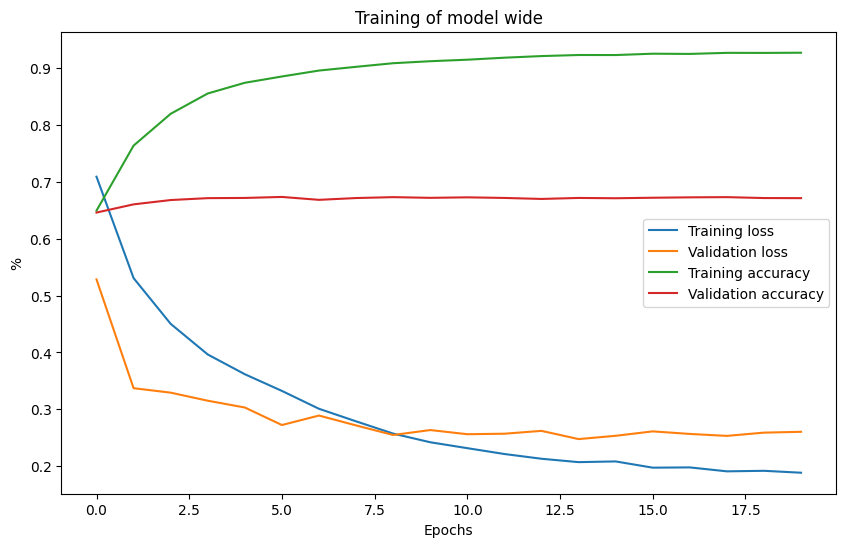

In [44]:
# Plot the training and validation loss
rst.plot_history(history_wide, "wide")

In [45]:
y_pred_wide = model_wide.predict(X_ts_wide)

# Calculate accuracy and precision of the model
accuracy_wide, precision_wide, recall_wide, f1_wide, mse_wide, mae_wide, r2_wide = rst.evaluate(y_pred_wide, y_ts, show_report=True)
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f}, MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")

165/165 [==============================] - 4s 12ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      4022
           1       0.89      0.90      0.89      1243

    accuracy                           0.95      5265
   macro avg       0.93      0.93      0.93      5265
weighted avg       0.95      0.95      0.95      5265

Accuracy = 0.9485, Precision = 0.9488, Recall = 0.9485, F1 Score = 0.9486, MSE = 0.0269, MAE = 0.0694, R-squared = 0.8325 -> wide


In [46]:
# Save the model
model_wide.save(os.path.join(models_folder, f'm_wide/wide_{start_time.date()}_{X_ts_wide.shape[1]}w.keras'))

---
#### 6. Another method for classification using machine learning is creating a Random Forest model:

- Random Forest works by creating lots of decision trees during training.
- The output of the Random Forest in our case will be 1 or 0 (exploration or not) according to the decision of most trees.
- It is a very simple model to triain.

In [47]:
from sklearn.ensemble import RandomForestClassifier
import joblib

In [48]:
# We train a RF model with the same data, but first we make it discrete
y_tr = (y_tr > 0.5).astype(int)

# Create the Random Forest model
RF_model = RandomForestClassifier(n_estimators = 24, max_depth = 12)

# Train the MultiOutputClassifier
RF_model.fit(X_tr, y_tr)

RandomForestClassifier(max_depth=12, n_estimators=24)

In [49]:
y_pred_RF = RF_model.predict(X_ts)

# Calculate accuracy and precision of the model
accuracy_RF, precision_RF, recall_RF, f1_RF, mse_RF, mae_RF, r2_RF = rst.evaluate(y_pred_RF, y_ts, show_report=True)
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f}, MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4022
           1       0.88      0.87      0.87      1243

    accuracy                           0.94      5265
   macro avg       0.92      0.92      0.92      5265
weighted avg       0.94      0.94      0.94      5265

Accuracy = 0.9411, Precision = 0.9409, Recall = 0.9411, F1 Score = 0.9410, MSE = 0.0470, MAE = 0.0698, R-squared = 0.7067 -> RF


In [50]:
# Save the model
joblib.dump(RF_model, os.path.join(models_folder, f'm_RF/RF_{start_time.date()}.pkl'))

['C:\\Users\\dhers\\Desktop\\RAINSTORM\\docs\\models\\m_RF/RF_2024-12-06.pkl']

---
#### 7. Finally, we can compare all the models we've trained

- Since we trained using the training dataset, and validated using the validation dataset... we test each model using the testing dataset.
- To compare each model with the performance of a human labeler, we shall meet again on the following notebook.

In [51]:
# Print the model results
print("Evaluate model vs testing data")

print("VS binary average")
print(f"Accuracy = {accuracy_simple:.4f}, Precision = {precision_simple:.4f}, Recall = {recall_simple:.4f}, F1 Score = {f1_simple:.4f} -> simple")
print(f"Accuracy = {accuracy_wide:.4f}, Precision = {precision_wide:.4f}, Recall = {recall_wide:.4f}, F1 Score = {f1_wide:.4f} -> wide")
print(f"Accuracy = {accuracy_RF:.4f}, Precision = {precision_RF:.4f}, Recall = {recall_RF:.4f}, F1 Score = {f1_RF:.4f} -> RF")

print("VS continuous average")
print(f"MSE = {mse_simple:.4f}, MAE = {mae_simple:.4f}, R-squared = {r2_simple:.4f} -> simple")
print(f"MSE = {mse_wide:.4f}, MAE = {mae_wide:.4f}, R-squared = {r2_wide:.4f} -> wide")
print(f"MSE = {mse_RF:.4f}, MAE = {mae_RF:.4f}, R-squared = {r2_RF:.4f} -> RF")

Evaluate model vs testing data
VS binary average
Accuracy = 0.9390, Precision = 0.9400, Recall = 0.9390, F1 Score = 0.9394 -> simple
Accuracy = 0.9485, Precision = 0.9488, Recall = 0.9485, F1 Score = 0.9486 -> wide
Accuracy = 0.9411, Precision = 0.9409, Recall = 0.9411, F1 Score = 0.9410 -> RF
VS continuous average
MSE = 0.0281, MAE = 0.0795, R-squared = 0.8250 -> simple
MSE = 0.0269, MAE = 0.0694, R-squared = 0.8325 -> wide
MSE = 0.0470, MAE = 0.0698, R-squared = 0.7067 -> RF
